In [1]:
#Last run date
import datetime
print (datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
import warnings
warnings.filterwarnings('ignore')

December 03, 2018 22:12:09


In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

# to make this notebook's output stable across runs
np.random.seed(42)

create_directory = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
if not(os.path.isdir(IMAGES_PATH)) and (create_directory):
    os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
from keras import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from itertools import permutations

Using TensorFlow backend.


In [4]:
#BK Import section
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import expon, reciprocal, uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [5]:
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/train.csv')

In [6]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Correlation between columns

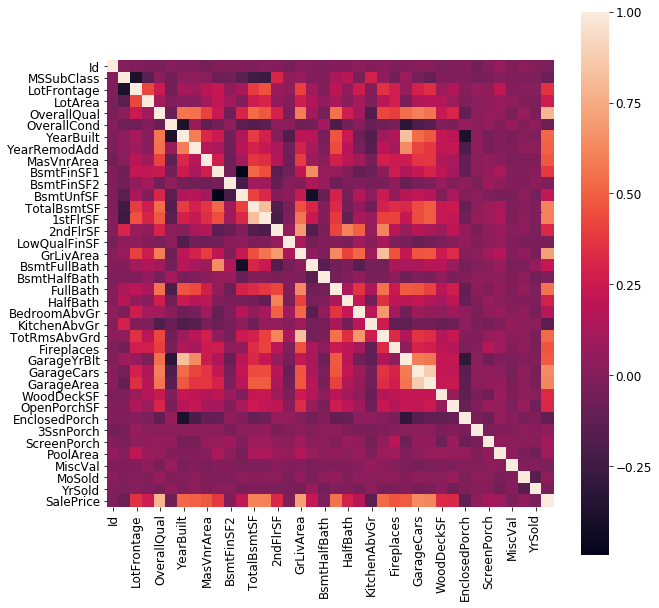

In [8]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, square=True)

Distribution of sale prices

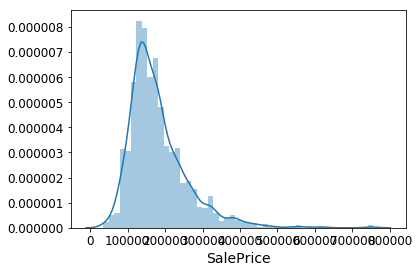

In [9]:
sns.distplot(df_train['SalePrice'])

sale price / year built chart

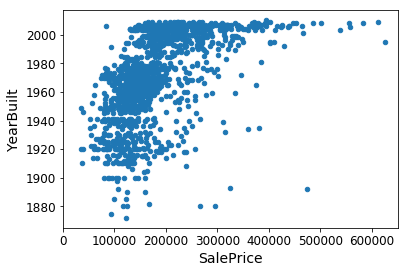

In [10]:
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
p = data.plot.scatter(x='SalePrice', y='YearBuilt', xlim=(0,650000))

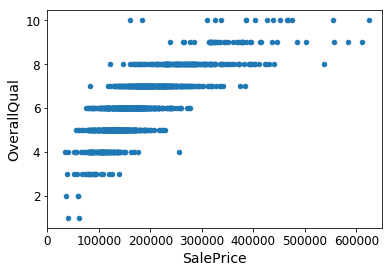

In [11]:
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
p = data.plot.scatter(x='SalePrice', y='OverallQual', xlim=(0,650000))

In [12]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [13]:
# New features
# The added features improved RMSE by 0.4% only
def PrepData (df):
    
    df['Years_after_Renov']=df['YrSold']-df['YearRemodAdd']
    df['Liv_area_over_LotArea']=df['GrLivArea']/df['LotArea']
    df['BedroomAbvGr'].replace(0, 1, inplace=True)
    df['Area_per_bedroom']=df['GrLivArea']/df['BedroomAbvGr']
    df['Qual_over_Cond']=df['OverallQual']/df['OverallCond']
    return df

In [14]:
# Data preparation

# remove outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

sale_price=df_train.pop('SalePrice')
df_train.drop(['Id'], inplace=True, axis=1)
df_te_ID = df_test.drop(['Id'], inplace=True, axis=1)

df_train=PrepData(df_train)
df_test=PrepData(df_test)

numerical_features_indices = np.where(df_train.dtypes != np.object)[0]
categorical_features_indices = np.where(df_train.dtypes == np.object)[0]

In [15]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', MinMaxScaler()),
    ])

cat_pipeline = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='most_frequent')), 
        ('cat_Encoder', OneHotEncoder(handle_unknown='ignore')), 
    ])

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, numerical_features_indices),
        ('cat', cat_pipeline, categorical_features_indices),
    ])

df_prep = full_pipeline.fit_transform(df_train)
print(df_prep.shape)

df_test = full_pipeline.transform(df_test)
print(df_test.shape)

(1458, 291)
(1460, 291)


In [16]:
train_X, val_X, train_y, val_y = train_test_split(df_prep, sale_price, random_state = 42, test_size=0.2)

# Baseline estimators

In [17]:
# Compare different models with the same input data
names = ["Linear Regression", "SVR","Ridge","Lasso","ElasticNet","SGDRegressor","KNeighbors Regressor",
         "Decision Tree Regressor", "Random Forest Regressor"]

baseline_regressors = [
    LinearRegression(), 
    SVR(kernel="linear"),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    SGDRegressor(random_state=42),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42)
]

# Create a dictionary for the regressor mapped to the rmse of baseline regressor
base_rmse = {}
# dict to store final models
final_models = {}

tuned_regressors = [
    LinearRegression(), 
    SVR(kernel="linear"),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    SGDRegressor(random_state=42),
    KNeighborsRegressor(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42)
]

In [18]:
def print_regressor_RMSE(X_tr, X_ts, y_tr, y_ts,regressors):
    for name, rgs in zip(names, regressors):
        rgs.fit(X_tr, y_tr)
        y_pred =rgs.predict(X_ts)
        rmse = np.sqrt(mean_squared_error(np.log(y_ts), np.log(y_pred))) 
        base_rmse[name] = rmse
        print('RMSE for {0} model is {1}'.format(name,  rmse))

In [19]:
%%time
print_regressor_RMSE(train_X, val_X, train_y, val_y,baseline_regressors)

RMSE for Linear Regression model is 0.26639529827352754
RMSE for SVR model is 0.40208104657058086
RMSE for Ridge model is 0.1458576461940676


C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE for Lasso model is 0.2584453809570658
RMSE for ElasticNet model is 0.2290609220450218
RMSE for SGDRegressor model is 0.16523338058558712
RMSE for KNeighbors Regressor model is 0.21635090793524026
RMSE for Decision Tree Regressor model is 0.20934907888211285
RMSE for Random Forest Regressor model is 0.15266543301399424
Wall time: 3.24 s


In [20]:
#The best three model with default parameters are  Lasso (28,166), Linear (29,511) and Ridge (30,081).

# Weak learning methods - tuned to new features (Boris)

In [21]:
%%time
#Hyper parameters optimization - Linear Regression

param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X':[True, False],
}

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=3,scoring='neg_mean_squared_error',verbose=5,n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s


Wall time: 2.55 s


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    2.3s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
print('The best parameters for Linear Regression model are:\n{0}\n'.format(grid_search.best_params_))
final_model=grid_search.best_estimator_
y_pred = final_model.predict(val_X)
rmse= np.sqrt(mean_squared_error(val_y, y_pred))
print('The RMSE for Linear Regression model is: {0}'.format(rmse))
print('The overall improvement with tuned hyper parameters is {0:.2%}'.format((25966.8028-rmse)/25966.8028))


The best parameters for Linear Regression model are:
{'copy_X': True, 'fit_intercept': False, 'normalize': True}

The RMSE for Linear Regression model is: 25950.527363090623
The overall improvement with tuned hyper parameters is 0.06%


In [23]:
# %%time
# #Hyper parameters optimization - SVR
# param_distribs = {
#         'kernel': ['linear', 'rbf'],
#         'C': reciprocal(20, 200000),
#         'gamma': expon(scale=1.0),
#     }
# rnd_search = RandomizedSearchCV(SVR(), param_distributions=param_distribs, n_iter=50, cv=5, 
#                                  scoring='neg_mean_squared_error', verbose=5, n_jobs=2, random_state=42)
# rnd_search.fit(train_X, train_y)

In [24]:
# print('The best parameters for SVR  model are:\n{0}\n'.format(rnd_search.best_params_))
# final_model=rnd_search.best_estimator_
# y_pred = final_model.predict(val_X)
# rmse= np.sqrt(mean_squared_error(val_y, y_pred))
# print('The RMSE for SVR model is: {0}'.format(rmse))
# print('The overall improvement with tuned hyper parameters is {0:.2%}'.format((75195.4241-rmse)/75195.4241))

In [25]:
%%time
#Hyper parameters optimization - Ridge 
param_grid = {
    'alpha': [1e-2,1e-1,1e0,1e1,1e2],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X':[True, False],
    'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

grid_search = GridSearchCV(Ridge(random_state=42), param_grid, cv=3,scoring='neg_mean_squared_error',verbose=5, n_jobs=-1)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   19.5s


Wall time: 22.7 s


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.4s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
print('The best parameters for Ridge model are:\n{0}\n'.format(grid_search.best_params_))
final_model=grid_search.best_estimator_
y_pred = final_model.predict(val_X)
rmse= np.sqrt(mean_squared_error(val_y, y_pred))
print('The RMSE for Ridge model is: {0}'.format(rmse))
print('The overall improvement with tuned hyper parameters is {0:.2%}'.format((23826.7363-rmse)/23826.7363))


The best parameters for Ridge model are:
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': False, 'normalize': True, 'solver': 'sag'}

The RMSE for Ridge model is: 23842.41608057537
The overall improvement with tuned hyper parameters is -0.07%


In [27]:
%%time
#Hyper parameters optimization - Lasso 
param_grid = {
    'alpha': [1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X':[True, False],
}


grid_search = GridSearchCV(Lasso(random_state=42, max_iter=1000), param_grid, cv=3,scoring='neg_mean_squared_error',verbose=5, n_jobs=-1)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  89 out of  96 | elapsed:    8.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    8.6s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 8.88 s


In [28]:
print('The best parameters for Lasso  model are:\n{0}\n'.format(grid_search.best_params_))
final_model=grid_search.best_estimator_
y_pred = final_model.predict(val_X)
rmse= np.sqrt(mean_squared_error(val_y, y_pred))
print('The RMSE for Lasso  model is: {0}'.format(rmse))
print('The overall improvement with tuned hyper parameters is {0:.2%}'.format((25864.9012-rmse)/25864.9012))

The best parameters for Lasso  model are:
{'alpha': 100, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

The RMSE for Lasso  model is: 22400.72333035708
The overall improvement with tuned hyper parameters is 13.39%


# Weak learning methods - tuned to old features (Rob)

In [29]:
# print the reults from the grid/random searchCV runs
def print_scores(estimator, display_threshold=40000):
    rbf_cvrs = estimator.cv_results_
    for mean_score, params in zip(rbf_cvrs["mean_test_score"], rbf_cvrs["params"]):
        if np.sqrt(-mean_score) < display_threshold:
            print(np.sqrt(-mean_score), params)

In [30]:
# evaluate using validation data
def validate_model(model_name, estimator, original_list=names, X=val_X, y=val_y):
    print('The best parameters for {0} model are:\n{1}\n'.format(model_name, grid_search.best_params_))
    final_models[model_name]=estimator.best_estimator_
    y_pred = final_models[model_name].predict(X)
    rmse= np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
    print('The RMSE for model is: {0:.5f}'.format(rmse))
    if model_name in original_list:
        print('The overall improvement with tuned hyper parameters is {0:.2%}'
              .format((base_rmse[model_name]-rmse)/base_rmse[model_name]))

## Linear regression optimization

In [31]:
%%time
#Hyper parameters optimization - Linear Regression
param_grid = {
    'fit_intercept': [True],
}

# oddly enough it seems that the best fit is the unchanged algorthim

grid_search = GridSearchCV(LinearRegression(), param_grid, cv=10,scoring='neg_mean_squared_error',verbose=1,n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Wall time: 1.07 s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.7s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [32]:
print_scores(grid_search)

27901.235979577214 {'fit_intercept': True}


In [33]:
validate_model('Linear Regression', grid_search)

The best parameters for Linear Regression model are:
{'fit_intercept': True}

The RMSE for model is: 0.26639
The overall improvement with tuned hyper parameters is 0.00%


## SVR optimization

In [34]:
%%time
#Hyper parameters optimization - SVR
param_distribs = {
    'kernel': ['rbf'],
    'C': [113564],
    'gamma': [0.0007790692366582295],
}

# oddly enough it seems that the best fit is the unchanged algorthim

rand_search = RandomizedSearchCV(SVR(), param_distributions=param_distribs, n_iter=1, cv=5, 
                                 scoring='neg_mean_squared_error', verbose=1, n_jobs=2, random_state=42)
rand_search.fit(train_X, train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.3s finished


Wall time: 2.9 s


In [35]:
print_scores(rand_search)

In [36]:
validate_model('SVR', rand_search)

The best parameters for SVR model are:
{'fit_intercept': True}

The RMSE for model is: 0.19893
The overall improvement with tuned hyper parameters is 50.53%


## Ridge regression optimization

In [37]:
%%time
#Hyper parameters optimization - Ridge
param_grid = {
    'alpha': [1.0],
    'fit_intercept': [True],
    #'solver': ['cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'auto'],
    'solver': ['auto'],
}

# oddly enough it seems that the best fit is the unchanged algorthim

grid_search = GridSearchCV(Ridge(random_state=42), param_grid, cv=3,scoring='neg_mean_squared_error',verbose=1,n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Wall time: 338 ms


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    0.1s finished


In [38]:
print_scores(grid_search)

26945.318801854704 {'alpha': 1.0, 'fit_intercept': True, 'solver': 'auto'}


In [39]:
validate_model('Ridge', grid_search)

The best parameters for Ridge model are:
{'alpha': 1.0, 'fit_intercept': True, 'solver': 'auto'}

The RMSE for model is: 0.14586
The overall improvement with tuned hyper parameters is 0.00%


## Lasso regression optimization

In [90]:
%%time
#Hyper parameters optimization - Lasso
param_grid = {
    'alpha': [71],
    'max_iter': [100],
}

# oddly enough it seems that the best fit is the unchanged algorthim

grid_search = GridSearchCV(Lasso(random_state=42), param_grid, cv=10,scoring='neg_mean_squared_error',verbose=1,n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Wall time: 722 ms


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.5s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [91]:
print_scores(grid_search)

25057.32619231869 {'alpha': 71, 'max_iter': 100}


In [92]:
validate_model('Lasso', grid_search)

The best parameters for Lasso model are:
{'alpha': 71, 'max_iter': 100}

The RMSE for model is: 0.13809
The overall improvement with tuned hyper parameters is 46.57%


## Elastic net optimization

In [102]:
%%time
#Hyper parameters optimization - Elastic Net
param_grid = {
    'alpha': [100],
    'l1_ratio': [1.0],
}

grid_search = GridSearchCV(ElasticNet(random_state=42), param_grid, cv=8,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Wall time: 869 ms


C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [103]:
print_scores(grid_search)

25038.513438627906 {'alpha': 100, 'l1_ratio': 1.0}


In [104]:
validate_model('ElasticNet', grid_search)

The best parameters for ElasticNet model are:
{'alpha': 100, 'l1_ratio': 1.0}

The RMSE for model is: 0.13824
The overall improvement with tuned hyper parameters is 39.65%


## SGDRegressor optimization - no regularization

In [46]:
%%time
#Hyper parameters optimization - SGDRegressor
param_grid = {
    'eta0': np.linspace(0.001, 0.1, num=20),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [50],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'power_t':[0.5],
    'penalty': ['none']
}

grid_search = GridSearchCV(SGDRegressor(random_state=42), param_grid, verbose=1, cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    3.7s


Wall time: 7.16 s


[Parallel(n_jobs=2)]: Done 960 out of 960 | elapsed:    7.0s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
print_scores(grid_search, display_threshold=28000)

27581.346292320493 {'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}
27023.755983272356 {'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'squared_epsilon_insensitive', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}
27581.346292320493 {'eta0': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_loss', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}
27023.755983272356 {'eta0': 0.001, 'learning_rate': 'adaptive', 'loss': 'squared_epsilon_insensitive', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}
27646.574567675216 {'eta0': 0.006210526315789474, 'learning_rate': 'constant', 'loss': 'squared_loss', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}
27646.574567675216 {'eta0': 0.006210526315789474, 'learning_rate': 'adaptive', 'loss': 'squared_loss', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}


In [51]:
validate_model('SGDRegressor', grid_search)

The best parameters for SGDRegressor model are:
{'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'squared_epsilon_insensitive', 'max_iter': 50, 'penalty': 'none', 'power_t': 0.5}

The RMSE for model is: 0.14529
The overall improvement with tuned hyper parameters is 12.07%


## SGDRegressor Optimization - with regularization
commented out because it runs 72000 fits with no performance increase.

In [52]:
# %%time
# #Hyper parameters optimization - SGDRegressor
# param_grid = [
#     {'eta0': np.linspace(0.001, 0.1, num=20),
#     'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#     'max_iter': [50],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'power_t':[0.5],
#     'penalty': ['l2','l1','elasticnet'],
#     'l1_ratio': np.linspace(0, 1, num=5),
#     'alpha': np.linspace(0.0001, 0.1, num=5),
#     }
# ]

# grid_search = GridSearchCV(SGDRegressor(random_state=42), param_grid, verbose=1, cv=3,scoring='neg_mean_squared_error', n_jobs=2)
# grid_search.fit(train_X, train_y)

In [53]:
# print_scores(grid_search)

In [54]:
# validate_model('SGDRegressor', grid_search)

## KNeighborsRegressor optimization

In [55]:
%%time
#Hyper parameters optimization - KNeighbors Regressor
param_grid = {
    'n_neighbors': np.arange(3,8),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'p': [1, 2]
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, verbose=1, cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.6s


Wall time: 7.47 s


[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    7.4s finished


In [56]:
print_scores(grid_search)

In [57]:
validate_model('KNeighbors Regressor', grid_search)

The best parameters for KNeighbors Regressor model are:
{'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

The RMSE for model is: 0.20128
The overall improvement with tuned hyper parameters is 6.96%


## Decision Tree Regressor optimization

In [58]:
# Print the most important features
def most_important_features(model, rgr_name, numResults=288, sort=True):
    important_features = []
    df = pd.DataFrame(df_prep.toarray()) 
    for name, score in zip(df.columns, model.feature_importances_):
        important_features.append((name, score))

    if sort:
        important_features.sort(key=lambda tup: tup[1], reverse=True)

    print('Top 10 features according to {}.\n'.format(rgr_name))
    print('Column # represents the column location in df_prep (with one_hot_encoding):\n')
    print('{:>12}{:>7}\n'.format('Column #', 'Score'))

    for name, score in important_features[0:numResults]:
        print('{:>12}: {:>8}'.format(name, score))

In [59]:
%%time
#Hyper parameters optimization - Decision Tree Regressor
param_grid = {
    'max_depth': np.append(np.arange(1,30+1,2), None),
    'min_samples_split': np.arange(2,30+1,2),
    'min_samples_leaf': [2],
    'max_features': ['auto'],
    #'max_leaf_nodes': np.append(np.arange(2,25), None),
    'max_leaf_nodes': [None], # none is the best every time
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, verbose=1, cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Wall time: 14.6 s


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   14.4s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [60]:
print_scores(grid_search, display_threshold=38416)

In [61]:
validate_model('Decision Tree Regressor', grid_search)

The best parameters for Decision Tree Regressor model are:
{'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 18}

The RMSE for model is: 0.19671
The overall improvement with tuned hyper parameters is 6.04%


In [62]:
# Print the most important features according to decision tree analysis
most_important_features(final_models['Decision Tree Regressor'], 'Decision Tree Regressor', numResults=5, sort=True)

Top 10 features according to Decision Tree Regressor.

Column # represents the column location in df_prep (with one_hot_encoding):

    Column #  Score

           3: 0.604596065987653
          15: 0.1244743808398337
          11: 0.10841636759937566
          22: 0.03323722112412952
           8: 0.02160527773683868


## Random Forest Regressor optimization

### RandomSearchCV

In [63]:
# %%time
# # Hyperparameters optimization - Random Forest Regressor
# # Use RandomSearchCV
# # 38min 58s run time with the following params:

# param_dist = {
#      'n_estimators': np.arange(1500,2000+1),
#      'max_depth': np.arange(15,25+1),
#      'max_features': np.arange(20,100+1),
#      'min_samples_split': np.arange(5, 7+1), 
#      'min_samples_leaf': [2], 
# }

# rand_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_dist, scoring='neg_mean_squared_error', 
#                                     n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=2)
# rand_search.fit(train_X, train_y)

In [64]:
# print_scores(rand_search)

In [65]:
# validate_model('Random Forest Regressor', rand_search)

# # --- results ----
# # The best parameters for Random Forest Regressor model are:
# # {'n_estimators': 1762, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 100, 'max_depth': 18}

# # The RMSE for Random Forest Regressor model is: 29175.04
# # The overall improvement with tuned hyper parameters is 12.10%

# # Labeled data mean = 178840, rmse/mean = 16.31%

### GridSearchCV

In [109]:
%%time
#Hyper parameters optimization - Random Forest Regressor
param_grid = {
    'n_estimators': [1000],
    'max_depth': [16],
    'max_features': [125],
    'min_samples_split': [2], 
    'min_samples_leaf': [2], 
    # 'max_leaf_nodes': np.arange(2, 100+1, 10) # does not help rmse_val
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           verbose=1, cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:  7.6min finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 8min 12s


In [110]:
print_scores(grid_search)

27430.12420759211 {'max_depth': 16, 'max_features': 125, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
27473.47480773836 {'max_depth': 16, 'max_features': 125, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1500}
27509.564033319126 {'max_depth': 16, 'max_features': 125, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}
27543.516021468648 {'max_depth': 16, 'max_features': 150, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
27520.461609351194 {'max_depth': 16, 'max_features': 150, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1500}
27554.794992876377 {'max_depth': 16, 'max_features': 150, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}
27792.23714049188 {'max_depth': 16, 'max_features': 200, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
27851.834241039174 {'max_depth': 16, 'max_features': 200, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estima

In [111]:
validate_model('Random Forest Regressor', grid_search)

The best parameters for Random Forest Regressor model are:
{'max_depth': 16, 'max_features': 125, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}

The RMSE for model is: 0.14660
The overall improvement with tuned hyper parameters is 3.98%


In [112]:
most_important_features(final_models['Random Forest Regressor'], 'Random Forest Regressor', numResults=5, sort=True)

Top 10 features according to Random Forest Regressor.

Column # represents the column location in df_prep (with one_hot_encoding):

    Column #  Score

           3: 0.282431044078157
          15: 0.12388375912788867
          25: 0.07771706686247805
          39: 0.06039431145324177
          11: 0.05384618813912052


# Aggregate learning methods

## BaggingRegressor

In [71]:
%%time
#Hyper parameters optimization - BaggingRegressor
from sklearn.ensemble import BaggingRegressor

param_grid = {
    'max_samples': [1.0],
    'max_features': [1.0],
    'n_estimators': [7],
    'bootstrap': [True],
#     'base_estimator': [final_models['Lasso'], final_models['Linear Regression'], final_models['ElasticNet'],
#                       final_models['SVR'], final_models['Ridge'], final_models['SGDRegressor'], LinearRegression(),
#                       Lasso(random_state=42)],
    'base_estimator': [final_models['SVR']]
}

bag_rgr = BaggingRegressor(n_jobs=2, random_state=42)

grid_search = GridSearchCV(estimator=bag_rgr, param_grid=param_grid, verbose=1, 
                           cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    3.3s finished


Wall time: 4.44 s


In [72]:
print_scores(grid_search, display_threshold=33200)

In [73]:
validate_model('BaggingRegressor', grid_search)

The best parameters for BaggingRegressor model are:
{'base_estimator': SVR(C=113564, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.0007790692366582295, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False), 'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 7}

The RMSE for model is: 0.19855


## GradientBoostingRegressor

In [74]:
%%time
#Hyper parameters optimization - GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    #'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.1],
    'n_estimators': [300],
    'subsample': [0.90], # less than 1.0 leads to lower variance and higher bias
    'min_samples_split': [50],
    'min_samples_leaf': [2],
    'max_depth': [6],
    'max_features': ['auto'],
    'max_leaf_nodes': [10],    
    'warm_start': [True]
}

gb_rgr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb_rgr, param_grid=param_grid, verbose=1, 
                           cv=3,scoring='neg_mean_squared_error', n_jobs=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    6.5s finished
C:\Users\Rob\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 11.1 s


In [75]:
print_scores(grid_search, display_threshold=26000)

24222.02467277612 {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 300, 'subsample': 0.9, 'warm_start': True}


In [76]:
validate_model('GradientBoostingRegressor', grid_search)

The best parameters for GradientBoostingRegressor model are:
{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 300, 'subsample': 0.9, 'warm_start': True}

The RMSE for model is: 0.11468


## Stacking

# Neural Network

Simple Neural Network with TensorBoard support

In [ ]:
tbCallBack = TensorBoard(log_dir='./uoft_ai_class_1/Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

In [ ]:
def train_model(neurons):
    print("neurons used", neurons)
    model = Sequential()

    model.add(Dense(neurons[0], activation='relu', input_dim=287))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(neurons[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = tf.train.RMSPropOptimizer(0.01)
    model.compile (loss = 'mse', optimizer = optimizer)

    hist = model.fit(train_X, train_y, epochs=1000, batch_size=32, validation_data = (val_X, val_y), callbacks=[tbCallBack])

    return hist

a = [8,16,32,64]
perms = set(permutations(a, 2))

for p in perms:
    res = train_model(p)
    history[p] = np.average([res.history['val_loss'][-1], res.history['val_loss'][-2]])


In [ ]:
history

# the key is the number of neurons in the first and second layer
# the value is the average validation loss of the last two epochs
# we should use the smallest network with 8 and 16 neurons in the two layers

In [ ]:
with open('final_proj_res_2.csv', 'w') as f:
    for k in history.keys():
        f.write(str(k))
        f.write(',')
        f.write(str(history[k]))
        f.write('\n')

In [ ]:
#Prediction output
best_model=Lasso(alpha=100, copy_X=True, fit_intercept=True, normalize= False,random_state=42)
best_model.fit(df_prep, sale_price)

In [ ]:
X_test_prep = full_pipeline.fit_transform(df_test) # BK: the transformation gives an error: 
                                                    #     could not convert string to float: 'RH'. 
                                                    # I can't understand a root cause so far. the test dataset is similar to 
                                                    # train one
final_pred = best_model.predict(X_test_prep)

In [ ]:
result=pd.DataFrame({'Id':df_test['Id'], 'SalePrice':final_pred},columns=['Id','SalePrice'])
result.to_csv('prediction_result.csv', index=False)